# Neural machine translation with attention

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from pathlib import Path

## Load integer addition data

In [2]:
def load(data_type, n_terms, n_digits):
    term_dig_dir = Path(f'{n_terms}term_{n_digits}digs')

    dir = Path('../Code') / Path('data') / Path(data_type) / term_dig_dir
    X_train = np.load(dir / Path('X_train.npy'), allow_pickle=True)
    X_test = np.load(dir / Path('X_test.npy'), allow_pickle=True)
    y_train = np.load(dir / Path('y_train.npy'), allow_pickle=True)
    y_test = np.load(dir / Path('y_test.npy'), allow_pickle=True)

    return X_train, X_test, y_train, y_test

In [43]:
X_train, X_test, y_train, y_test = load('random', 3, 2)

In [4]:
X_train.shape

(7000, 6)

In [5]:
X_train[0]

array([ 3,  1, 10,  7,  1, 12])

In [6]:
y_train.shape

(7000, 5)

In [7]:
y_train[0]

array([11,  1,  0,  2, 12])

In [8]:
X_train.shape, y_train.shape

((7000, 6), (7000, 5))

In [9]:
X_test.shape, y_test.shape

((3000, 6), (3000, 5))

In [44]:
def char_to_int_map(max_value=9, min_value=0):
    char_to_int = {str(n): n for n in range(min_value, max_value+1)}
    n_terms = max_value - min_value + 1
    char_to_int['+'] = n_terms
    char_to_int['\t'] = n_terms + 1
    char_to_int['\n'] = n_terms + 2
    char_to_int[' '] = n_terms + 3
    return char_to_int

char_to_int = char_to_int_map()
int_to_char = {v: k for k, v in char_to_int.items()}

def decode(v):
    return int_to_char[v]

In [45]:
''.join([decode(x) for x in X_train[0]])

'7+12+91\n '

In [46]:
''.join([decode(x) for x in y_train[0]])

'\t110\n'

### Create a tf.data dataset

In [47]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 32
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
embedding_dim = 13
units = 256
bidir = True
vocab_inp_size = len(char_to_int)
vocab_tar_size = len(char_to_int)

# Data is already padded, so we can just grab any one
max_length_inp = len(X_train[0])
max_length_targ = len(y_train[0])

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

In [48]:
example_input_batch, example_target_batch = next(iter(train_ds))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 9]), TensorShape([32, 5]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [49]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, bidir):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.bidir = bidir
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name='Encoder_Embedding')
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='Encoder_GRU')
        if bidir:
            self.bidir_gru = tf.keras.layers.Bidirectional(self.gru, name='Encoder_BidirGRU')

    def call(self, x, hidden):
        x = self.embedding(x)
        if not self.bidir:
            output, state = self.gru(x, initial_state = hidden)
        else:
            hidden = [hidden, hidden]
            output, forward_state, reverse_state = self.bidir_gru(x, initial_state = hidden)
            state = tf.concat([forward_state, reverse_state], axis=1)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [50]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, bidir)

In [51]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, bidir):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units, name='Attn_W1')
        self.W2 = tf.keras.layers.Dense(units, name='Attn_W2')
        self.V = tf.keras.layers.Dense(1, name='Attn_V')
        self.bidir = bidir

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [52]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, bidir):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.bidir = bidir
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name='Decoder_Embedding')
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='Decoder_GRU')
        if bidir:
            self.bidir_gru = tf.keras.layers.Bidirectional(self.gru, name='Decoder_BidirGRU')
        self.fc = tf.keras.layers.Dense(vocab_size, name='Decoder_FC')

        # used for attention
        self.attention = BahdanauAttention(self.dec_units, self.bidir)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        if not self.bidir:
            output, state = self.gru(x)
        else:
            output, forward_state, reverse_state = self.bidir_gru(x)
            state = tf.concat([forward_state, reverse_state], axis=1)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [53]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, bidir)

## Define the optimizer and the loss function

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # Mask whitespace first
    mask = tf.math.logical_not(tf.math.equal(real, char_to_int[' ']))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [54]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [22]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        # print(f'enc_output.shape = {enc_output.shape}')
        # print(f'enc_hidden.shape = {enc_hidden.shape}')

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([char_to_int['\t']] * BATCH_SIZE, 1)
        dec_input = tf.dtypes.cast(dec_input, tf.float32)
        # print(f'dec_input.shape = {dec_input.shape}')

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # print(f'predictions.shape = {predictions.shape}')
            # print(f'dec_hidden.shape = {dec_hidden.shape}')

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [23]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_ds.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        # if batch % 100 == 0:
        #   print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
        #                                                batch,
        #                                                batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                  total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 1.2315
Time taken for 1 epoch 21.358434200286865 sec

Epoch 2 Loss 0.9888
Time taken for 1 epoch 13.86460280418396 sec

Epoch 3 Loss 0.9604
Time taken for 1 epoch 16.978954076766968 sec

Epoch 4 Loss 0.9051
Time taken for 1 epoch 13.825186967849731 sec

Epoch 5 Loss 0.7358
Time taken for 1 epoch 12.523950099945068 sec

Epoch 6 Loss 0.5397
Time taken for 1 epoch 12.253431797027588 sec

Epoch 7 Loss 0.3576
Time taken for 1 epoch 11.092602014541626 sec

Epoch 8 Loss 0.2800
Time taken for 1 epoch 13.771574020385742 sec

Epoch 9 Loss 0.1879
Time taken for 1 epoch 13.155783891677856 sec

Epoch 10 Loss 0.1527
Time taken for 1 epoch 12.979116678237915 sec

Epoch 11 Loss 0.1067
Time taken for 1 epoch 13.403764009475708 sec

Epoch 12 Loss 0.1046
Time taken for 1 epoch 12.581562995910645 sec

Epoch 13 Loss 0.0749
Time taken for 1 epoch 12.053032875061035 sec

Epoch 14 Loss 0.0662
Time taken for 1 epoch 12.693876028060913 sec

Epoch 15 Loss 0.0518
Time taken for 1 epoch 12.57716727256

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [55]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # Preprocess the input
    inputs = [char_to_int[i] for i in sentence]
    inputs = np.array(inputs).reshape(1, -1)
    inputs = tf.convert_to_tensor(inputs)

    # Start with a blank result
    result = ''

    # Initial hidden state is zeros
    hidden = tf.zeros((1, units))

    # Encode the input
    enc_out, enc_hidden = encoder(inputs, hidden)

    # Use the encoder's final hidden state as the dec's initial hidden state
    dec_hidden = enc_hidden
  
    # Start by feeding the decoder the starting character 
    dec_input = tf.expand_dims([char_to_int['\t']], 0)

    for t in range(max_length_targ):
        # Continually decode the current result, and store the attention weights for plotting
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += int_to_char[predicted_id]

        if predicted_id == char_to_int['\n']:
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [56]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='Reds')

    fontdict = {'fontsize': 14}
    sentence = list(sentence)
    # Appending a \n doesn't jive with padding, need to fix this
    sentence[-1] = r'\n'
    predicted_sentence = list(predicted_sentence)
    predicted_sentence[-1] = r'\n'

    xticks = [''] + sentence
    yticks = [''] + predicted_sentence
    ax.set_xticklabels(xticks, fontdict=fontdict)
    ax.set_yticklabels(yticks, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [57]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # attention_plot = attention_plot[:len(result), :len(sentence)]
    plot_attention(attention_plot, sentence, result)

## Restore the latest checkpoint and test

In [58]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [59]:
def generate_example_plot(input=None, idx=None):
    output = None
    if idx is None and input is None:
        idx = np.random.randint(X_test.shape[1])
    if input is None:
        input = X_test[idx]
        output = y_test[idx]
    if not isinstance(input, str):
        test_input = ''.join([decode(x) for x in input])
    else:
        test_input = input
    translate(test_input)

    if output is not None:
        print(f'Actual: {"".join([decode(x) for x in output]).strip()}')

Input: 26+5+37
 
Predicted translation: 32



<ipython-input-56-c1de69a79c6e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, fontdict=fontdict)
<ipython-input-56-c1de69a79c6e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, fontdict=fontdict)


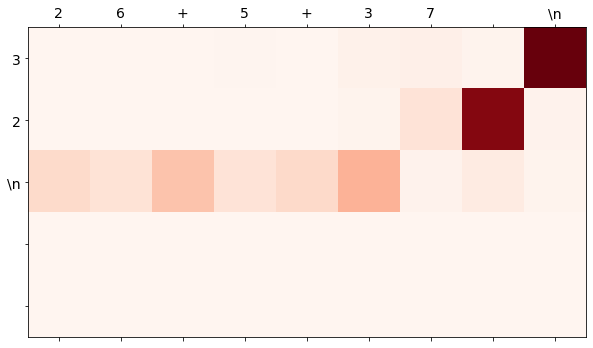

Actual: 68


In [64]:
generate_example_plot()

## Test set results

In [30]:
correct_cnt = 0
incorrect_attn_plots = dict()

for x, y in zip(X_test[:100], y_test[:100]):
    input = ''.join([decode(i) for i in x])
    result, sentence, attention_plot = evaluate(input)
    result = result.strip()
    actual = ''.join([decode(i) for i in y]).strip()
    if result == actual:
        correct_cnt += 1
    else:
        incorrect_attn_plots[(input, result, actual)] = attention_plot
        print(f'Actual = {actual}, result = {result}')

Actual = 90, result = 91
Actual = 71, result = 61
Actual = 43, result = 42


input = 82+8, result = 91, actual = 90


<ipython-input-25-c1de69a79c6e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, fontdict=fontdict)
<ipython-input-25-c1de69a79c6e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, fontdict=fontdict)


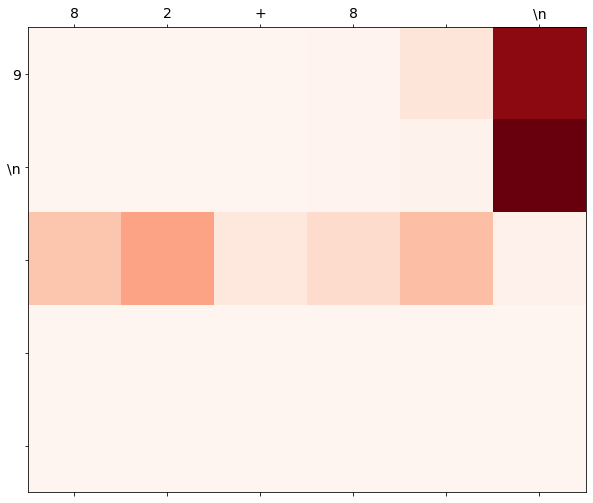

input = 70+1, result = 61, actual = 71


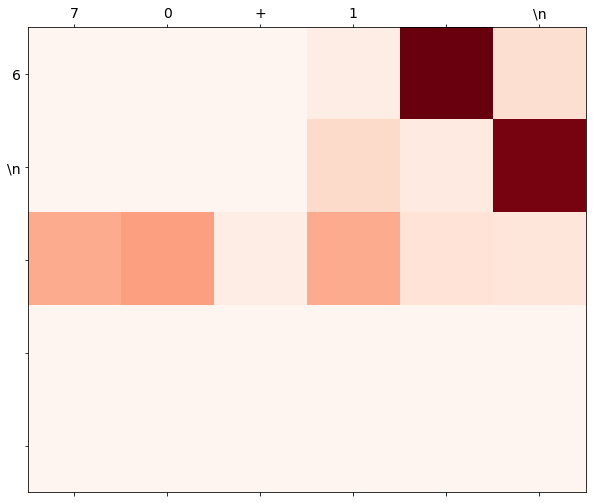

input = 36+7, result = 42, actual = 43


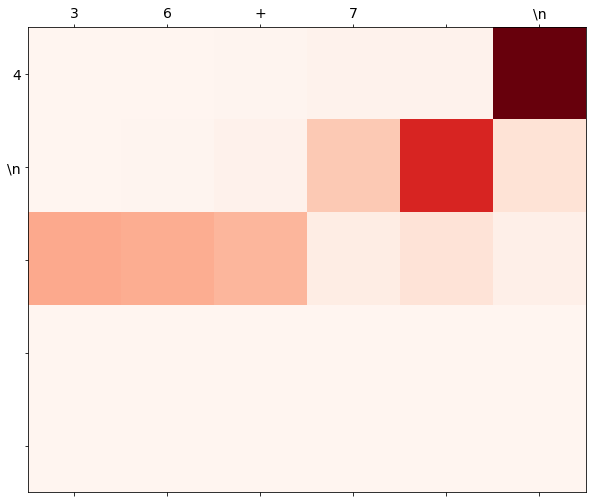

In [31]:
for k, attention_plot in incorrect_attn_plots.items():
    sentence, result, actual = k
    print(f'input = {sentence.strip()}, result = {result}, actual = {actual}')
    plot_attention(attention_plot, sentence, result)
    print('='*100)

Input: 0+12
 
Predicted translation: 12



<ipython-input-25-c1de69a79c6e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, fontdict=fontdict)
<ipython-input-25-c1de69a79c6e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, fontdict=fontdict)


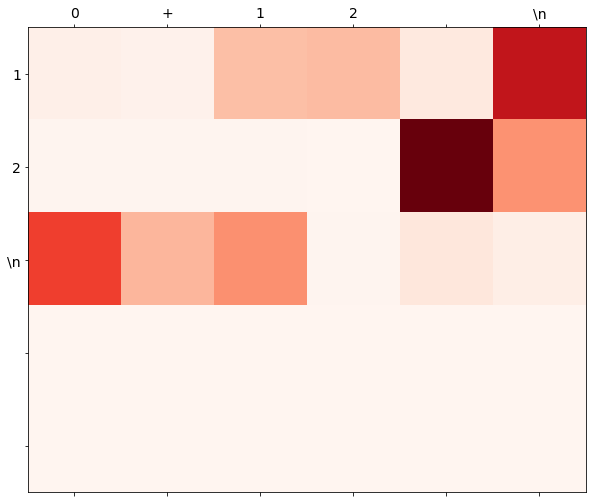

In [32]:
generate_example_plot(input='0+12\n ')